# Искусственный интеллект
## Классификация полных изображений с помощью transfer learning

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import PIL

import torch
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [4]:
random_state = 0xDEAD
np.random.seed(random_state)
torch.random.manual_seed(random_state)
torch.cuda.random.manual_seed_all(random_state);

## Загрузка датасета
### Oxford pets

In [6]:
!tar xfz images.tar.gz

Поместим каждый класс в отдельную папку.

In [7]:
images = os.listdir('images')

In [8]:
def get_class(string):
    for i, ch in enumerate(string):
        if ch.isdigit():
            return string[:i-1]

In [9]:
classes = list(set([get_class(img) for img in images if get_class(img) is not None]))
classes

['beagle',
 'pug',
 'saint_bernard',
 'japanese_chin',
 'Siamese',
 'great_pyrenees',
 'newfoundland',
 'samoyed',
 'leonberger',
 'yorkshire_terrier',
 'Russian_Blue',
 'american_pit_bull_terrier',
 'american_bulldog',
 'boxer',
 'keeshond',
 'scottish_terrier',
 'wheaten_terrier',
 'pomeranian',
 'basset_hound',
 'Ragdoll',
 'english_setter',
 'Bombay',
 'staffordshire_bull_terrier',
 'British_Shorthair',
 'Abyssinian',
 'havanese',
 'german_shorthaired',
 'Persian',
 'Maine_Coon',
 'miniature_pinscher',
 'Birman',
 'Egyptian_Mau',
 'shiba_inu',
 'Sphynx',
 'chihuahua',
 'english_cocker_spaniel',
 'Bengal']

Сразу поделим датасет на трейн и вал. Под валидацию оставим 20% картинок

In [10]:
os.makedirs('./dataset')
os.makedirs('./dataset/train')
os.makedirs('./dataset/val')
val_size = 0.2

for cl in classes:
    os.makedirs(os.path.join('dataset/train', cl))
    os.makedirs(os.path.join('dataset/val', cl))

In [11]:
for i, image in enumerate(images):
    cur_class = get_class(image)
    if cur_class is None:
        continue
    if np.random.random(1) < 1 - val_size:
        shutil.copy(os.path.join('images', image), os.path.join('dataset/train', cur_class))
    else:
        shutil.copy(os.path.join('images', image), os.path.join('dataset/val', cur_class))

Сразу преобразуем картинки к тензору и нормируем их

In [20]:
transform = transforms.Compose([
                                transforms.Resize((128, 128)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

train_dataset = datasets.ImageFolder('/Users/amino/jupyter/dataset/train', transform=transform)
val_dataset = datasets.ImageFolder('/Users/amino/jupyter/dataset/val', transform=transform)

In [21]:
len(train_dataset), len(val_dataset)

(5881, 1509)

Сделаем даталоадеры

In [22]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

## Функции для обучения модели

In [23]:
def train_model(model, train_loader, test_loader, epochs_num, optimizer, criterion, device):
    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []

    for epoch in range(epochs_num):
        cur_train_acc = 0
        cur_test_acc = 0

        cur_train_loss = 0
        cur_test_loss = 0

        model.train()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            cur_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            cur_train_acc += (y_batch.squeeze() == torch.argmax(y_pred, axis=1)).cpu().numpy().sum()
            
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                y_pred = model(X_batch)
                cur_test_acc += (y_batch.squeeze() == torch.argmax(y_pred, axis=1)).cpu().numpy().sum()

                loss = criterion(y_pred, y_batch)
                cur_test_loss += loss.cpu().item()

        
        train_acc_history.append(cur_train_acc / (len(train_loader) * batch_size))
        test_acc_history.append(cur_test_acc / (len(test_loader) * batch_size))
        train_loss_history.append(cur_train_loss / (len(train_loader) * batch_size))
        test_loss_history.append(cur_test_loss / (len(test_loader) * batch_size))
    
    return train_loss_history, test_loss_history, train_acc_history, test_acc_history

In [24]:
def plot_loss_history(train_loss_history, test_loss_history):
    plt.figure(figsize=(10, 8))
    plt.title("Loss")
    plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, linewidth=2, label='train loss')
    plt.plot(range(1, len(test_loss_history) + 1), test_loss_history, linewidth=2, label='test loss')
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [25]:
def plot_acc_history(train_acc_history, test_acc_history):
    plt.figure(figsize=(10, 8))
    plt.title("Accuracy")
    plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, linewidth=2, label='train accuracy')
    plt.plot(range(1, len(test_acc_history) + 1), test_acc_history, linewidth=2, label='test accuracy')
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

Построение матрицы неточностей:

In [26]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, test_loader):
    preds = None
    reals = None
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)
            if preds is None:
                preds = torch.argmax(y_pred, axis=1).cpu().numpy()
                reals = y_batch.cpu().numpy()
            else:
                preds = np.hstack([preds, torch.argmax(y_pred, axis=1).cpu().numpy()])
                reals = np.hstack([reals, y_batch.cpu().numpy()])

    confustion_matrix = confusion_matrix(reals, preds)
    df_cm = pd.DataFrame(confustion_matrix, index = [i for i in classes], columns = [i for i in classes])
    plt.figure(figsize = (15, 15))
    sns.heatmap(df_cm, annot=True, cmap='Blues')
    plt.show()

## Обучение моделей

Попробуем дообучить VGG16

In [28]:
vgg = models.vgg16(pretrained=True)

C:\Users\amino\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\amino\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\amino/.cache\torch\hub\checkpoints\vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [29]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Заменим последний слой классификатора, чтобы он подходил по размеру под наш датасет

In [30]:
vgg.classifier[6] = nn.Linear(4096, len(classes))

In [31]:
vgg = vgg.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=1e-4)

epochs = 2

In [34]:
vgg_stats = train_model(vgg, train_loader, val_loader, epochs, optimizer, criterion, device)

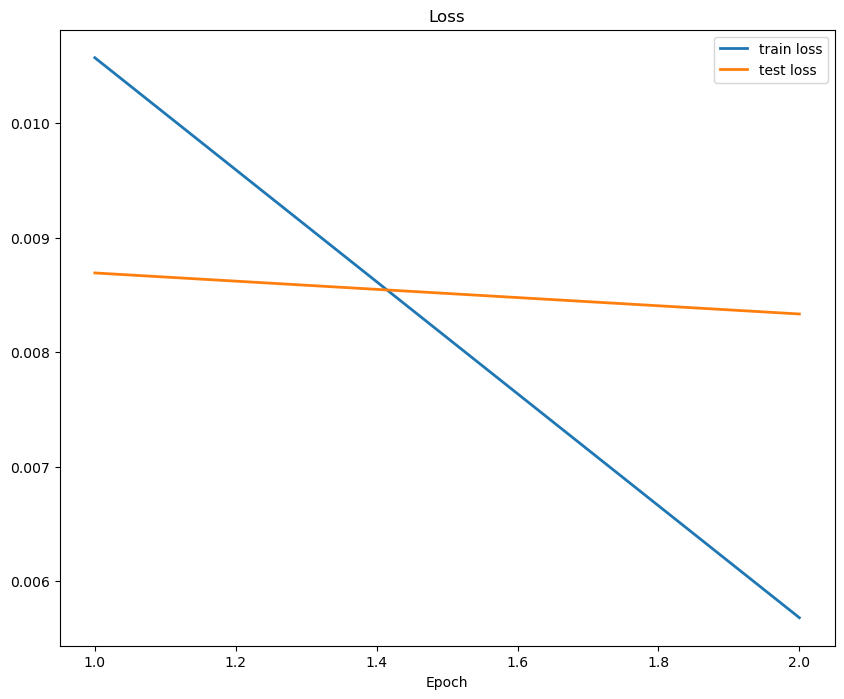

In [35]:
plot_loss_history(vgg_stats[0], vgg_stats[1])

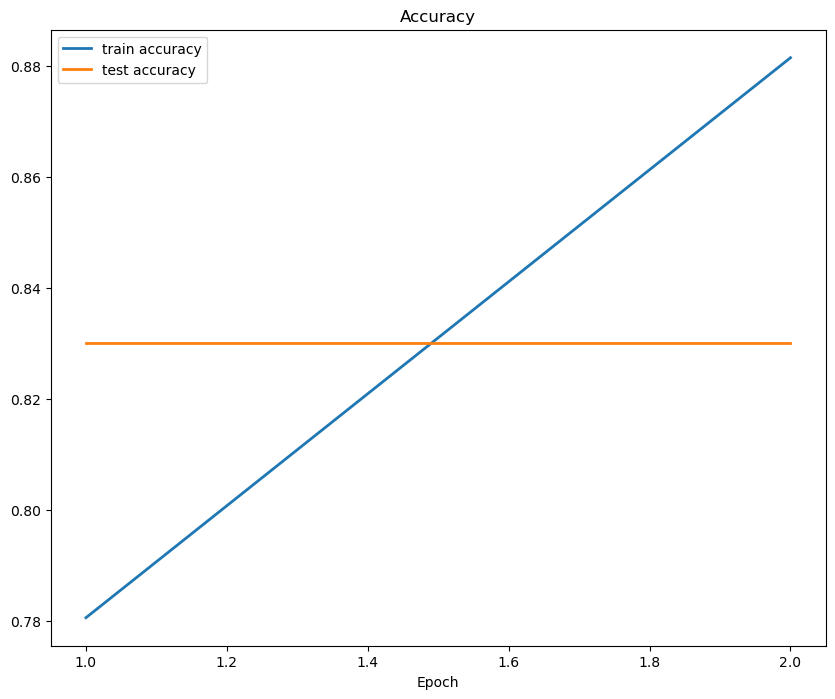

In [36]:
plot_acc_history(vgg_stats[2], vgg_stats[3])

In [37]:
print('Final accuracy =', vgg_stats[3][-1])

Final accuracy = 0.8301630434782609


In [26]:
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [27]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
resnet.fc = nn.Linear(512, len(classes))

In [29]:
resnet = resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)

epochs = 2

In [30]:
resnet_stats = train_model(resnet, train_loader, val_loader, epochs, optimizer, criterion, device)

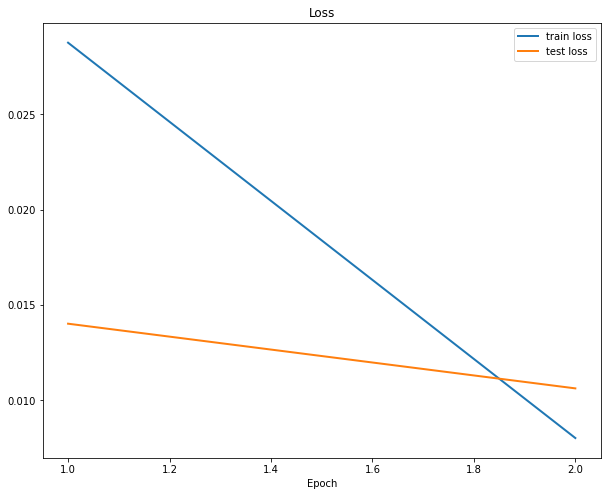

In [31]:
plot_loss_history(resnet_stats[0], resnet_stats[1])

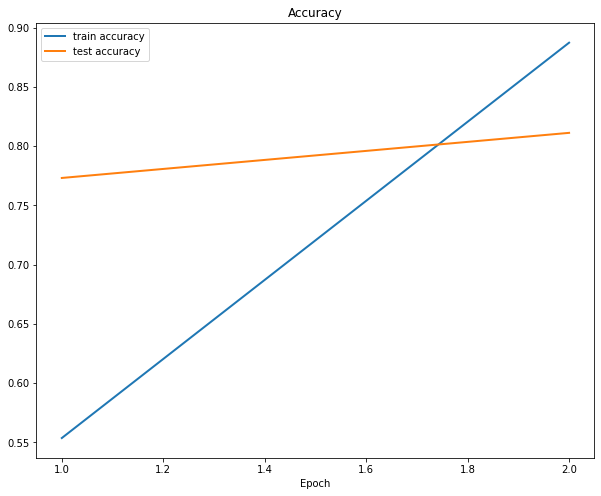

In [32]:
plot_acc_history(resnet_stats[2], resnet_stats[3])

In [33]:
print('Final accuracy =', resnet_stats[3][-1])

Final accuracy = 0.811141304347826


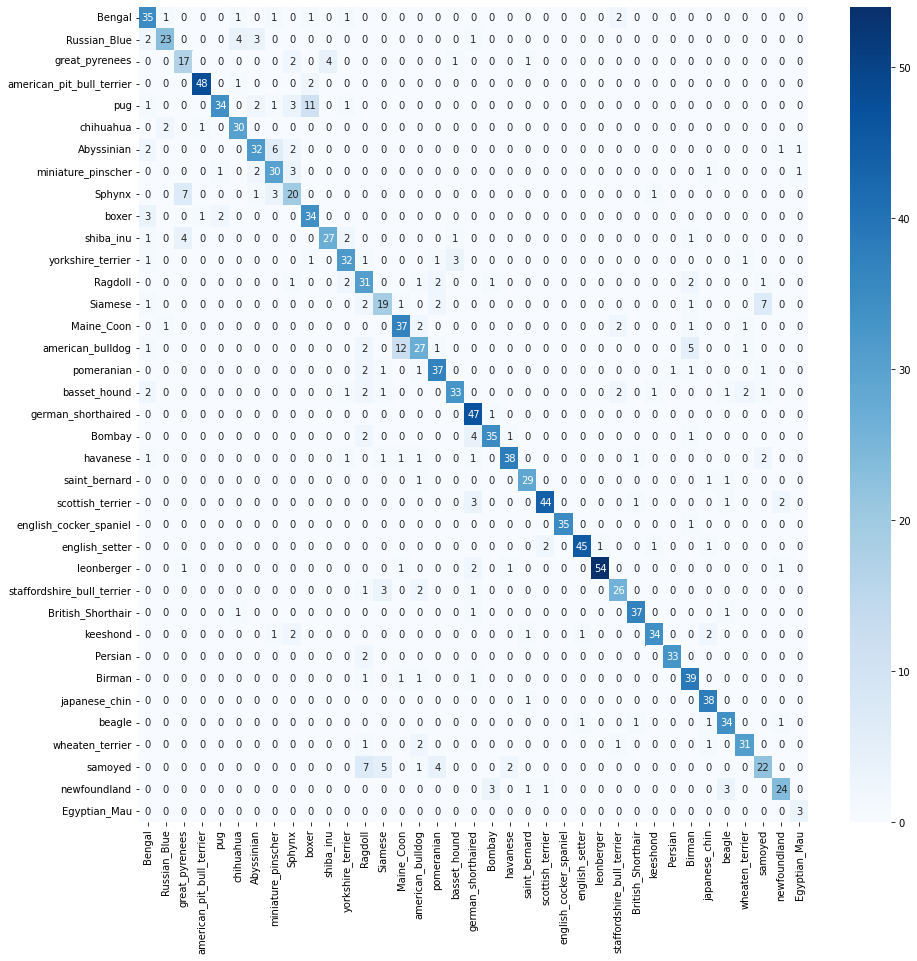

In [34]:
plot_confusion_matrix(resnet, val_loader)